In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Data -- 289 people * 32 EEG nodes * 183 frequencies in power spectra

mat = scipy.io.loadmat('data/DataOpen.mat')
data = np.array(mat['DataOpen'])

# Trait data -- 289 people * 5 traits - values are 0 or 1
trait_data = scipy.io.loadmat('data/Classes.mat')
trait_data = np.array(trait_data['Classes'])
trait_data = pd.DataFrame(trait_data)

traits = ['Neuroticism' ,'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

In [3]:
# Shuffles X and y in unison
def shuffleXY(X,y):
    assert len(X) == len(y)
    permutation = np.random.permutation(len(X))
    return (X.iloc[permutation], y.iloc[permutation])

# Performs cross-validation, returns the mean accuracy
def performCrossVal(model, X, y, cv=10, repetitions=10):
    cross_val_scores = []
    for i in range(repetitions):
        shuf_X, shuf_y = shuffleXY(X, y)
        scores = cross_val_score(model, shuf_X, shuf_y, cv=10, scoring='accuracy', n_jobs=1)
        cross_val_scores.append(scores.mean())
    return np.mean(cross_val_scores)


In [4]:
# Flatten the data -- results in a 289 x 5856 2d array

flattened_data = []

for person_data in data:
    flat = np.ndarray.flatten(person_data)
    flattened_data.append(flat)
    
flattened_data_df = pd.DataFrame(flattened_data)

## Random forest classifier

In [77]:
rfc = RFC(n_estimators=25, max_depth=8)
rf_accs = []
for i in range(len(traits)):
    acc = performCrossVal(rfc, flattened_data_df, trait_data[i], repetitions=10)
    rf_accs.append(acc)
    print(traits[i] + " classification accuracy with RF:", acc)

Neuroticism classification accuracy with RF: 0.5309211822660098
Extraversion classification accuracy with RF: 0.5242857142857141
Openness classification accuracy with RF: 0.5085
Agreeableness classification accuracy with RF: 0.5221650246305418
Conscientiousness classification accuracy with RF: 0.5094178981937603


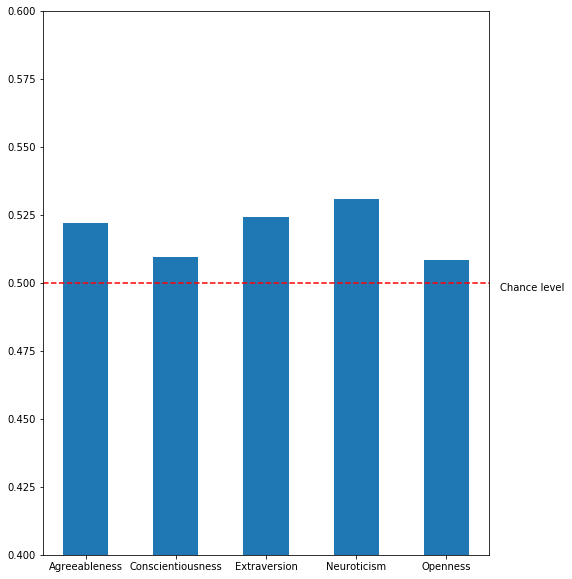

In [78]:
plt.figure(figsize=(8,10))
plt.bar(traits, rf_accs, width=0.5)
plt.ylim(0.4, 0.6)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.text(4.6, 0.497, 'Chance level')
plt.show()

## PCA

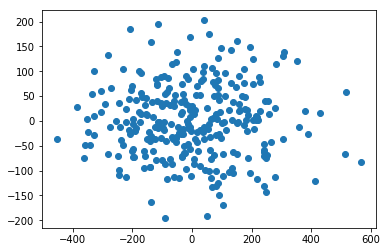

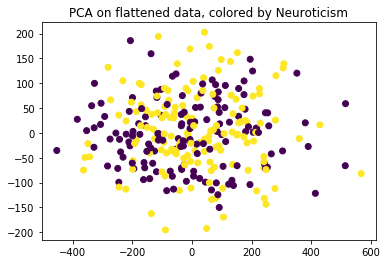

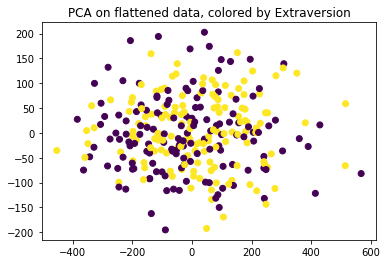

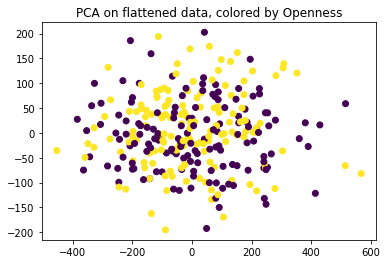

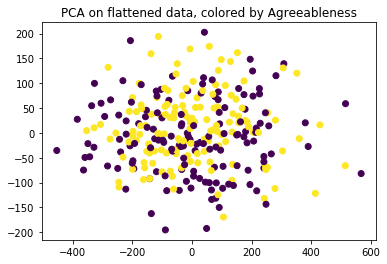

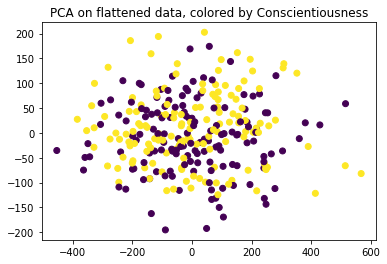

In [4]:
pca = PCA(n_components=2, svd_solver='full')
transf_flat_data = pca.fit_transform(flattened_data)
plt.scatter(transf_flat_data[:,0], transf_flat_data[:,1])
plt.show()

for i in range(len(traits)):
    plt.scatter(transf_flat_data[:,0], transf_flat_data[:,1], c=trait_data[i])
    plt.title("PCA on flattened data, colored by " + traits[i])
    plt.show()
    

## t-SNE

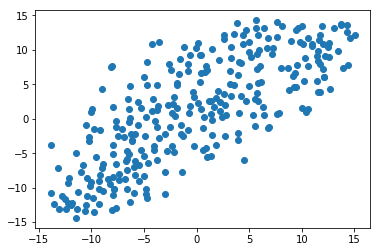

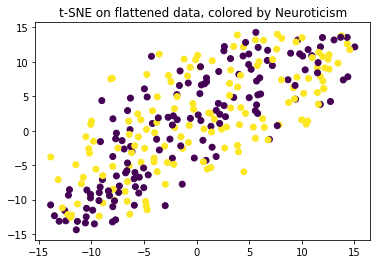

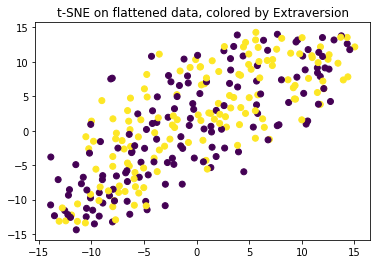

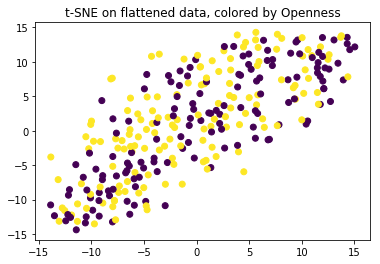

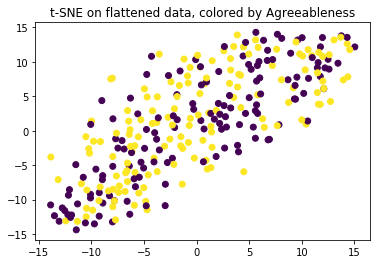

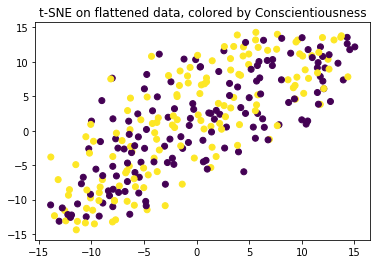

In [87]:
tsne = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=50, random_state=0)
pca_transf = pca.fit_transform(flattened_data)
transf_flat_data = tsne.fit_transform(pca_transf)

plt.scatter(transf_flat_data[:,0], transf_flat_data[:,1])
plt.show()

for i in range(len(traits)):
    plt.scatter(transf_flat_data[:,0], transf_flat_data[:,1], c=trait_data[i])
    plt.title("t-SNE on flattened data, colored by " + traits[i])
    plt.show()
    

## SVC

In [36]:
from sklearn.svm import SVC

def find_c_value(X, y):
    accuracies = []
    
    c_base = 0.000001
    step = 0.00001
    for i in range(10):
        c = c_base + i*step
        svc = SVC(C=c, kernel='linear')
        accuracies.append((c,performCrossVal(svc, X, y, repetitions=1)))
    return sorted(accuracies, key=lambda x: x[1], reverse=True)[0][0]

In [37]:
from sklearn.model_selection import StratifiedKFold

def perform_K_fold_SVC(X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    
    accuracies = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pca = PCA(n_components=7)
        pca.fit(X_train)
        transf_X_train = pd.DataFrame(pca.transform(X_train))
        
        # Find best c-value on train data
        c = find_c_value(transf_X_train, y_train)
        
        svc = SVC(C=c, kernel='linear')
        svc.fit(transf_X_train, y_train)

        transf_X_test = pca.transform(X_test)
        preds = svc.predict(transf_X_test)
        accuracies.append(accuracy_score(y_test, preds))
    return np.mean(accuracies)

In [28]:
from time import time
start = time()
k_fold_acc = []
for t in range(len(traits)):
    k_fold_acc.append(perform_K_fold_SVC(flattened_data_df, trait_data[t]))
print(k_fold_acc)
print("time it took:", (time()-start))

[0.5640886699507389, 0.5668226600985221, 0.49151888341543515, 0.5317077175697865, 0.5094663382594418]
time it took: 24.9186007976532


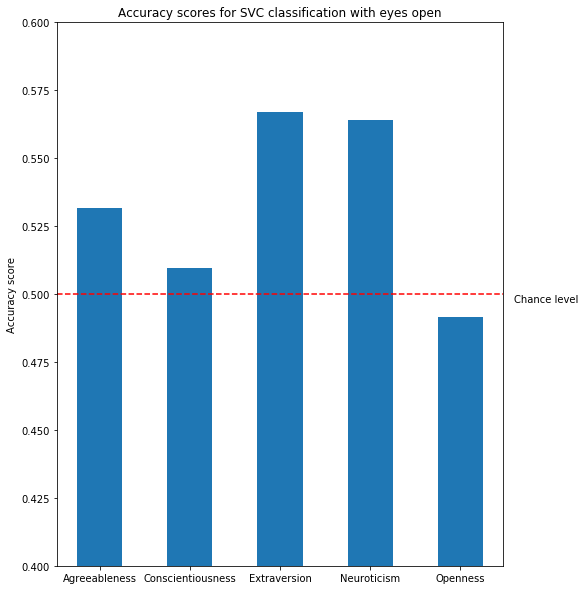

In [75]:

plt.figure(figsize=(8,10))
plt.bar(traits, k_fold_acc, width=0.5)
plt.ylim(0.4, 0.6)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.text(4.6, 0.497, 'Chance level')
plt.ylabel('Accuracy score')
plt.title('Accuracy scores for SVC classification with eyes open')
plt.show()

In [60]:
# Permutation test for Extraversion

perm_accs_extraversion= []
for i in range(500):
    if (i % 25 == 0):
        print(i)
    trait_data_shuf = trait_data.sample(frac=1).reset_index(drop=True)
    X = flattened_data_df
    y = trait_data_shuf[1]
    perm_accs_neuroticism.append(perform_K_fold_SVC(X,y))


0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


Text(0,0.5,'Frequency')

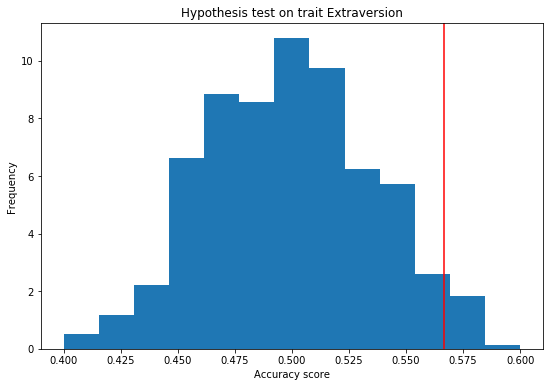

In [61]:
plt.figure(figsize=(9,6))
plt.hist(perm_accs_extraversion, bins=13, range=(0.4, 0.6), normed=True)
plt.axvline(k_fold_acc[1], color='r')
plt.title('Hypothesis test on trait Extraversion')
plt.xlabel('Accuracy score')
plt.ylabel('Frequency')

In [80]:
a = np.array(perm_accs_neuroticism)
print(len(a[a > 0.565])/500)

0.03


In [24]:
# Permutation test for Neuroticism

perm_accs_extraversion = []
for i in range(500):
    if (i % 25 == 0):
        print(i)
    trait_data_shuf = trait_data.sample(frac=1).reset_index(drop=True)
    X = flattened_data_df
    y = trait_data_shuf[0]
    perm_accs_extraversion.append(perform_K_fold_SVC(X,y))

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


Text(0,0.5,'Frequency')

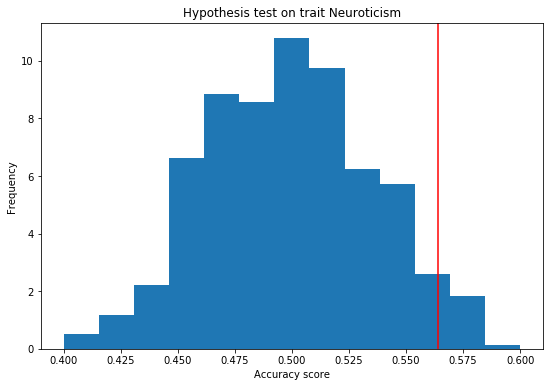

In [59]:
plt.figure(figsize=(9,6))
plt.hist(perm_accs_extraversion, bins=13, range=(0.4, 0.6), normed=True)
plt.axvline(k_fold_acc[0], color='r')
plt.title('Hypothesis test on trait Neuroticism')
plt.xlabel('Accuracy score')
plt.ylabel('Frequency')

## Classifying eyes open or closed

In [46]:
closed_mat = scipy.io.loadmat('data/DataClose.mat')
closed_data = np.array(closed_mat['DataClose'])
closed_flattened_data = []

for person_data in closed_data:
    flat = np.ndarray.flatten(person_data)
    closed_flattened_data.append(flat)
    
closed_flattened_data_df = pd.DataFrame(closed_flattened_data)

eyes_open_half = flattened_data_df.iloc[:145]
eyes_closed_half = closed_flattened_data_df.iloc[145:]

concat_data = pd.concat([eyes_open_half, eyes_closed_half], axis=0)
eyes_open_y = pd.DataFrame(np.concatenate([np.ones(145, dtype=np.int8), np.zeros(144, dtype=np.int8)], axis=0))

In [47]:
rfc = RFC(n_estimators=25, max_depth=8)
eyes_open_acc = performCrossVal(rfc, concat_data, eyes_open_y[0], repetitions=10)
print("Eyes open/closed classification accuracy with RF:", eyes_open_acc)

Eyes open/closed classification accuracy with RF: 0.8095935960591133
